In [242]:
import numpy as np
import matplotlib.pyplot as plt

Vi genererar slumpmässig datapunkter uniformt på $[0,1]^2$

In [243]:
np.random.seed(133)
N = 30 #number of data points
x = np.random.uniform(0,1, size = (N,2))

Sedan så definerar vi ett plan (eller en linje eftersom vi är i 2d) så om punkterna ligger ovanför så får de label y = 1 0ch ligger de under får de label y= 0

linjens exvation ges av $\vec{n}\cdot \vec{x} = c$ så punkterna får label 1 om 
$$ \vec{n}\cdot \vec{x} > c $$

In [244]:
#n,c are the parameters fo for the hyperplane separating the two sets n*x=c
n = np.array([1,2])
c = 1.2
y = np.zeros((N,)) #labels
for i in range(N):
    if (np.dot(n,x[i,:])>c):
        y[i] = 1

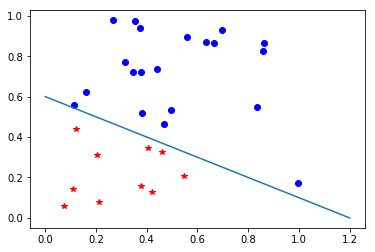

In [245]:
plt.plot(x[y==0,0],x[y==0,1],'r*') #plots all points with albels 0
plt.plot(x[y==1,0],x[y==1,1],'bo') #plots all points with labels 1
plt.plot([0,c/n[0]],[c/n[1],0]) #plots the separating hyperplane

Nu ska vi göre en logistisk regression. Vi har modellen 
$$f_{\omega_0,\omega_1,\omega_2}(x_1,x_2) = P(Y = 1|x,\vec{\omega}) = \frac{1}{1+e^{-(\omega_0 + \omega_1 x_1 + \omega_2 x_2)}} = \frac{e^{(\omega_0 + \omega_1 x_1 + \omega_2 x_2)}}{1+e^{(\omega_0 + \omega_1 x_1 + \omega_2 x_2)}}$$
Och loss funktionen
$$L(f_{\omega_0,\omega_1,\omega_2}(x_1,x_2),y) = -y\log(f_{\omega_0,\omega_1,\omega_2}(x_1,x_2)) - (1-y)\log(1-f_{\omega_0,\omega_1,\omega_2}(x_1,x_2))$$
Så lossen för all våran data är
$$L = -\sum_{i=0}^N y^i\log(f_{\omega_0,\omega_1,\omega_2}(x^i_1,x^i_2)) + (1-y^i)\log(1-f_{\omega_0,\omega_1,\omega_2}(x^i_1,x^i_2))$$
Det är den här lossen vi vill minimera med någon metod. Alltså hitta de optimala parametrarna $\omega_0,\omega_1,\omega_2$

# First order solutions  

## Solution with stochastic gradient descent


Vår vektor x är en Nx2 vektor, dvs vi har N datapunkter och två features per datapunkt. Vi vill dessutom lägga till en "bias-neuron", dvs vi antar att det faktiskt finns tre indata attribut för varje datapunkt, x_1, x_2 och 1. Det innebär att vi behöver tre vikter, en för varje indata attribut. Därför skapar vi en vektor w med tre element. Dessutom behöver vi några parametrar som bestämmer hur algoritmen beter sig

In [246]:
w = np.zeros((3, ))
epochs = 50
L_list = np.zeros((epochs,))  # save loss development
alfa = 1                      # learning rate

Logistisk funktion och loss funktion som ovan

In [311]:
## all functions take "scalar" indata


# activation function => logistic function
def sigmoid(x, w):
    a = w[0] + w[1]*x[0]  + w[2]*x[1]     # use vector mul. later
    return 1.0/(1.0 + np.exp(-a))
    
def loss(y, f):
    #return -y*np.log(f) - (1-y)*np.log(1 - f)   # since y in {0, 1}, one of the two parts vanishes each time 
    if y == 1:
        return - np.log(f)
    else:
        return - np.log(1-f)
    

Vi behöver dessutom gradienten av loss funktionen med avseende på vikterna, 
$ \frac{\partial L}{\partial w_i} $. För att ta fram det använder vi kedjeregeln: det är lätt att bestämma derivatan av loss funktionen med avseende på $f$,  $\frac{\partial L}{\partial f}$, eftersom $f$ är "direkt" indata till $L$. På samma sätt kan vi enkelt bestämma $\frac{partial f}{\partial a}$ (derivatan av activation function med avseende på pre activation värdet) och derivatan av $a$ med avseende på $w_i$. Totalt får vi
$$ \frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial f} \frac{\partial f}{\partial a} \frac{\partial a}{\partial w_i}$$

In [314]:
def loss_gradient(y, f, x, w):
    a = w[0] + w[1]*x[0]  + w[2]*x[1] # som ovan -> väldigt ineffektiv att ta fram två gånger, bara för tydlighet
    #dL_df = -y/f + (1-y)/(1-f)
    if y == 1:
        dL_df = -1./f
    else:
        dL_df = 1./(1-f)
    
    df_da = np.exp(-a)/(1 + np.exp(-a))**2
    da_dw = np.array([1, x[0], x[1]])
    dL_dw = dL_df*df_da*da_dw
    return dL_dw
    
 
'''
def loss_gradient(y, f, x, w):
    a = w[0] + w[1]*x[0]  + w[2]*x[1] 
    dL_dw = np.array([1, x[0], x[1]])/(1 + np.exp(-a))    
    if y == 1:
        dL_dw *= -np.exp(-a)
    return dL_dw
'''    

För logistisk regression går det också att bestämma $\frac{dL}{dw}$ "direkt",
$$\frac{dL}{dw} = -y*(1 - \sigma(W\cdot X))*X + (1-y)*\sigma(W\cdot X)*X $$
där X = [1, x], dvs

$$ \frac{dL}{dw} = \begin{cases}
\frac{- exp(-w \cdot X) X }{1 + exp(- w \cdot X)} & y = 1 \\
\frac{X }{1 + exp(- w \cdot X)} & y = 0 \\
\end{cases}
$$

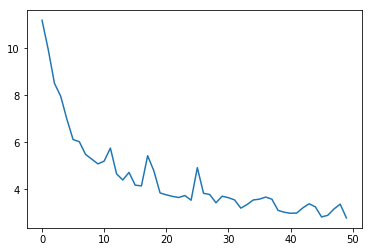

In [315]:
w = np.zeros((3, ))
epochs = 50
L_list = np.zeros((epochs,))  # save loss development
alfa = 1                      # learning rate

# stochastic gradient descent
for i in range(epochs):
    for j in range(N):
        # choose one data point
        ind = np.random.choice(N)
        x_ind = x[ind, :]
        y_ind = y[ind]
    
        f = sigmoid(x_ind, w)
        dL_dw = loss_gradient(y_ind, f, x_ind, w)

        w = w - alfa*dL_dw
    
    # every N iterations: check loss function value
    L_tot = 0
        
    # add upp values for all x_i    
    for j in range(N):
        x_ind = x[j, :]
        y_ind = y[j]
        
        f = sigmoid(x_ind, w)
        L_tot += loss(y_ind, f)
            
    L_list[i] = L_tot
                
plt.plot(L_list)

In [250]:
L_list

array([13.89820243,  9.22990022,  8.16290006,  7.27276807,  6.71019172,
        6.31613523,  5.75036901,  5.43634243,  5.62490514,  4.96280184,
        5.06995275,  4.99728111,  4.82302968,  4.31827011,  4.4763475 ,
        4.88920155,  4.094057  ,  4.3135432 ,  4.41476223,  3.77820134,
        4.12169168,  3.71785167,  3.63616062,  4.3637283 ,  4.48095552,
        3.49274424,  3.74208398,  3.67425491,  3.44224701,  3.27630494,
        3.3852308 ,  3.180979  ,  3.497174  ,  3.09779444,  3.34174839,
        3.39721192,  2.97890341,  3.77447331,  3.19007693,  3.58378788,
        3.58242228,  3.5944531 ,  2.82111347,  2.7935789 ,  2.87902258,
        2.73517625,  2.71034936,  2.79164318,  2.79681204,  2.90531299])

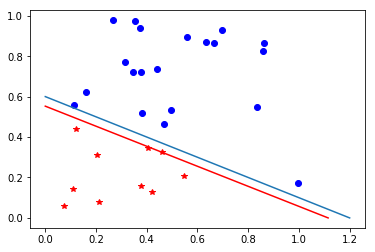

In [251]:
plt.plot(x[y==0,0],x[y==0,1],'r*') #plots all points with albels 0
plt.plot(x[y==1,0],x[y==1,1],'bo') #plots all points with labels 1
plt.plot([0,c/n[0]],[c/n[1],0]) #plots the separating hyperplane
plt.plot([0,-w[0]/w[1]],[-w[0]/w[2],0],'r')

### Solution with more vector notation

In [365]:
# activation function => logistic function
def sigmoid(X, w):
    a = np.dot(X, w)
    f = 1.0/(1.0 + np.exp(-a))
    df_da = np.exp(-a)/(1 + np.exp(-a))**2
    return f, df_da
    
def loss(y, f):
    L = -np.dot(y, np.log(f)) - np.dot((1-y), np.log(1 - f))   # since y in {0, 1}, one of the two parts vanishes each time 
    return L

def loss_grad(y, f):
    dL_df = -y/f + (1-y)/(1-f)    
    #if y == 1:
    #    dL_df = -1./f
    #else:
    #    dL_df = 1./(1-f)
    return dL_df

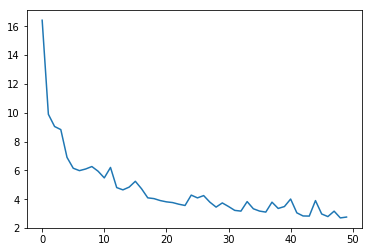

In [366]:
w = np.zeros((3, ))
epochs = 50
L_list = np.zeros((epochs,))  # save loss development
alfa = 1                      # learning rate

# stochastic gradient descent
for i in range(epochs):
    for j in range(N):
        # choose one data point
        ind = np.random.choice(N)
        X_ind = np.array([1, *x[ind, :]])
        y_ind = y[ind]
    
        (f, df_da) = sigmoid(X_ind, w)
        dL_df = loss_grad(y_ind, f)
        dL_dw = dL_df*df_da*X_ind

        w = w - alfa*dL_dw
    
    # every N iterations: check loss function value
    L_tot = 0
        
    # add upp values for all x_i    
    for j in range(N):
        X_ind = np.array([1, *x[j, :]])
        y_ind = y[j]
        
        f, df_da = sigmoid(X_ind, w)
        L_tot += loss(y_ind, f)
            
    L_list[i] = L_tot
                
plt.plot(L_list)

In [254]:
w

array([-9.79206117,  6.94799692, 15.5324664 ])

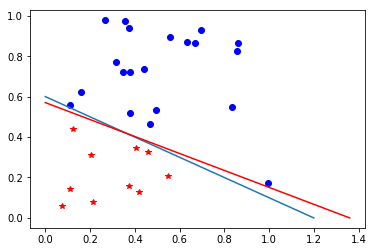

In [266]:
plt.plot(x[y==0,0],x[y==0,1],'r*') #plots all points with albels 0
plt.plot(x[y==1,0],x[y==1,1],'bo') #plots all points with labels 1
plt.plot([0,c/n[0]],[c/n[1],0]) #plots the separating hyperplane
plt.plot([0,-w[0]/w[1]],[-w[0]/w[2],0],'r')

## Solution with gradient descent

In [267]:
# activation function => logistic function
def sigmoid(X, W):
    a = np.dot(X, W.T)
    f = 1.0/(1.0 + np.exp(-a))
    df_da = np.exp(-a)/(1 + np.exp(-a))**2
    return f, df_da
    
def loss(y, f):
    L = -np.dot(y, np.log(f)) - np.dot((1-y), np.log(1 - f))   # since y in {0, 1}, one of the two parts vanishes each time 
    return L

def loss_grad(y, f):
    dL_df = -y/f + (1-y)/(1-f)    
    #if y == 1:
    #    dL_df = -1./f
    #else:
    #    dL_df = 1./(1-f)
    return dL_df

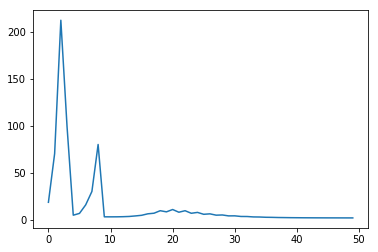

In [400]:
W = np.random.rand(3, )
epochs = 50
L_list = np.zeros((epochs,))  # save loss development
alfa = 1                    # learning rate

X = np.ones((N, 3))
X[:, 1:] = x

# gradient descent
for i in range(epochs):
    
    (f, df_da) = sigmoid(X, W)
    dL_df = loss_grad(y, f)

    dL_da = np.multiply(dL_df, df_da)
    dL_dw = np.dot(dL_da.T, X)

    W = W - alfa*dL_dw
    
    # check value of loss function
    L_list[i] = loss(y, f)

                
plt.plot(L_list)
